# Start cells one by one and configure `path_to_model_weight
## Image size (height, width) = (64, 256) or less
## prompt 1: write letters on image less than height size like on examples images for better recognition 

In [1]:
# Recommended Python 3.9.19
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [8]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "  # The set of valid characters
max_str_len = 34                             # Maximum length of input labels
num_of_characters = len(alphabets) + 1       # Number of unique characters, plus 1 for CTC pseudo-blank
num_of_timestamps = 64                       # The maximum length of predicted labels

In [9]:
# Fuction to preprocess the img
def preprocess(img):
    (h, w) = img.shape                                    # Getting the height & width of the image
    
    final_img = np.ones([64, 256])*255                    # Blank white image
    
    # crop    
    if h > 64:
        img = img[:64, :]                                 # If the h>64 then it is cropped to 64
        
    if w > 256:
        img = img[:, :256]                                # If the w>256 then it is cropped to 256
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE) # Rotate 90° Clockwise & return

In [10]:
def label_to_num(label):
    return np.array([alphabets.find(ch) for ch in label])


def num_to_label(num):
    return ''.join([alphabets[ch] for ch in num if ch != -1])

blank_label = -1

In [11]:
path_to_model_weight = 'trained_model_13_3.h5' # the best model weight
#path_to_model_weight = 'trained_model_12_3.h5' # previous version


# Define the input layer with a shape of (256, 64, 1) for grayscale images
input_data = Input(shape=(256, 64, 1), name='input')

# Convolutional Layer 1: 32 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)  # Batch normalization
inner = Activation('relu')(inner)  # ReLU activation
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # Max-pooling

# Convolutional Layer 2: 64 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

# Convolutional Layer 3: 128 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# Reshape the output for sequence processing
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)

# Fully Connected Layer 1: 64 units, ReLU activation, He normal initialization
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# Bidirectional LSTM Layers: 256 units, return sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output Layer: Number of characters, He normal initialization
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)  # Softmax activation
# Create the model with input and output layers
model = Model(inputs=input_data, outputs=y_pred)

model.load_weights(path_to_model_weight)

# The ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # The 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


# Define input placeholders for true labels, input sequence length, and label sequence length
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Calculate CTC loss using the ctc_lambda_func function
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Create the final model that takes input data, true labels, input length, and label length
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
# Compile the final model with a dummy loss lambda function (loss calculation occurs elsewhere)
# The optimizer used is Adam with a learning rate of 0.0001
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))

In [12]:
def predict(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = preprocess(image)
    image = image / 255.

    print('prepared image to analyse')
    plt.imshow(image)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=-0.8)
    plt.show()

    # Reshape the image to have a batch size of 1
    image = image.reshape(1, 256, 64, 1)

    pred = model.predict(image)
    decoded =  tf.keras.backend.get_value( tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])

    return num_to_label(decoded[0])

prepared image to analyse


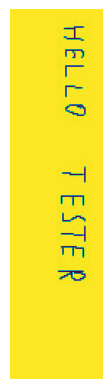

1/1 [==============================] - 0s 83ms/step
prediction  HELLO TESTER


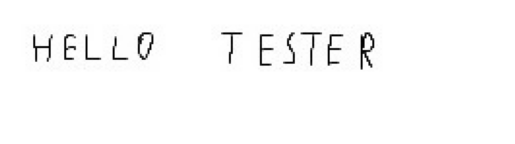

In [15]:
#my_image = cv2.imread('./test_v2/test/TEST_0014.jpg')
my_image = cv2.imread('test_empty_image.jpg')
print('prediction ', predict(my_image))

plt.imshow(my_image)
plt.axis('off')
plt.subplots_adjust(wspace=0.4, hspace=-0.8)
plt.show()